<a href="https://colab.research.google.com/github/tomonari-masada/course2021-sml/blob/main/BoxCox_transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 全ての特徴量をBox-Cox変換しようとしてみる

## 準備

* インポート

In [ ]:
import numpy as np
from scipy import stats, special
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_format = 'retina'

* データの取得

In [ ]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

housing = load_housing_data()

---

* `ocean_proximity`を削除
 * こうしないといけない、というわけではない。

In [ ]:
housing_num = housing.drop('ocean_proximity', axis=1)

* 説明変数と目的変数を分離
* 訓練データ、検証データ、テストデータへ分割

In [ ]:
X = housing_num.drop('median_house_value', axis=1)
y = housing_num["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

* 欠損値を含む行を削除
 * こうしないといけない、というわけではない。

In [ ]:
na_index = X_train.isna().any(axis=1)
X_train = X_train[~ na_index]
y_train = y_train[~ na_index]

na_index = X_valid.isna().any(axis=1)
X_valid = X_valid[~ na_index]
y_valid = y_valid[~ na_index]

na_index = X_test.isna().any(axis=1)
X_test = X_test[~ na_index]
y_test = y_test[~ na_index]

print(X_train.shape, X_valid.shape, X_test.shape)

(13209, 8) (3303, 8) (3921, 8)


* 元のデータをコピーして保存しておく

In [ ]:
X_train_original = X_train.copy()
X_valid_original = X_valid.copy()
X_test_original = X_test.copy()

## そのままで予測性能を測る
* SGDRegressorをStandardScalerと組み合わせて使ってみる。
 * 演習の時間には説明していないが、課題への提出で使っている人がいたので。

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

reg = make_pipeline(StandardScaler(), SGDRegressor(random_state=123))
reg.fit(X_train, y_train)
y_valid_pred = reg.predict(X_valid)
rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
print(f'RMSE: {rmse:.1f}')

RMSE: 70902.8


---

## 説明変数を列挙

In [ ]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

* 以下、これらの説明変数のすべてをBox-Cox変換しようと努力してみる・・・。

## longitudeのBox-Cox変換

* Box-Cox変換は変換は正の実数でないと適用できないので、絶対値をとる。
* 絶対値のヒストグラムをチェックしておく。

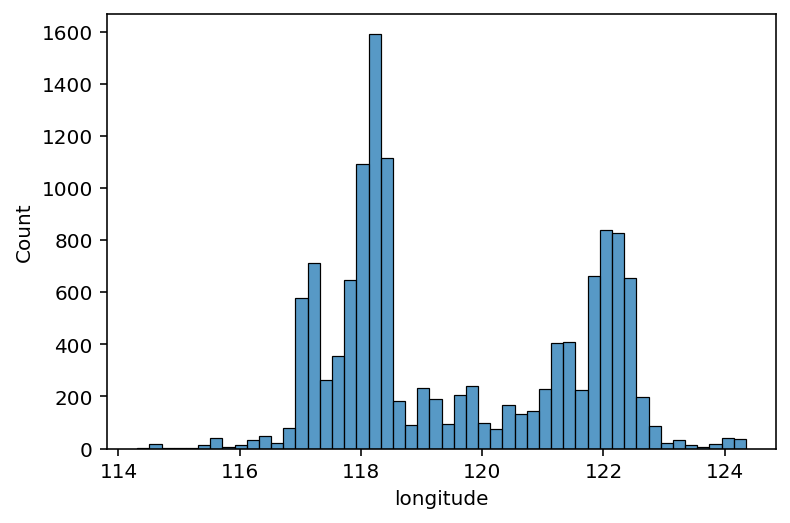

In [ ]:
sns.histplot(X_train.longitude.abs(), bins=50)

* Box-Cox変換すると、二つ、結果が返ってくるので、別々に受け取ること。
 * 説明を読むこと。→ https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html
 * 一つ目は、変換した結果。
 * 二つ目は、変換する際に使ったパラメータ。これは与えられたデータ集合を使って計算されている。

In [ ]:
boxcox_lon, maxlog_lon = stats.boxcox(X_train.longitude.abs())

* 変換後の値をチェックする。
 * 何かおかしい。

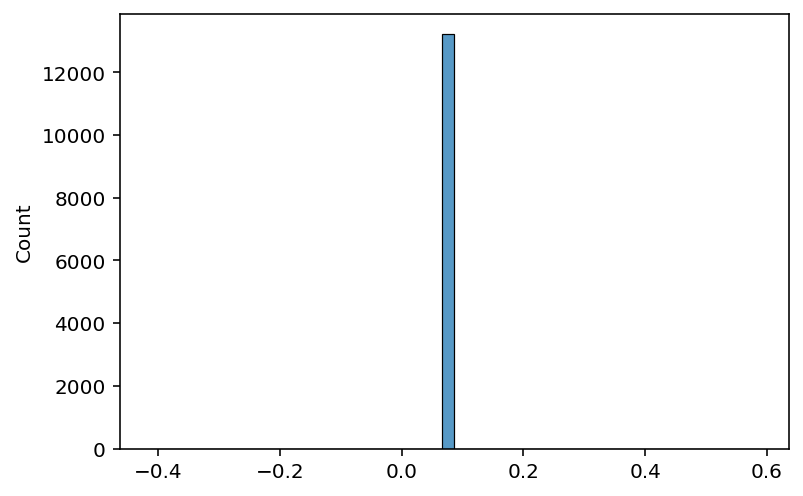

In [ ]:
sns.histplot(boxcox_lon, bins=50)

In [ ]:
np.unique(boxcox_lon)

array([0.08689146])

* 全てが一つの値にまとまってしまっている。

* 以下のように、例えば50を引いてから変換すると問題ない。
 * 50は適当に選んだ数値。もっとちゃんと選ぶには、どうすればいいか。

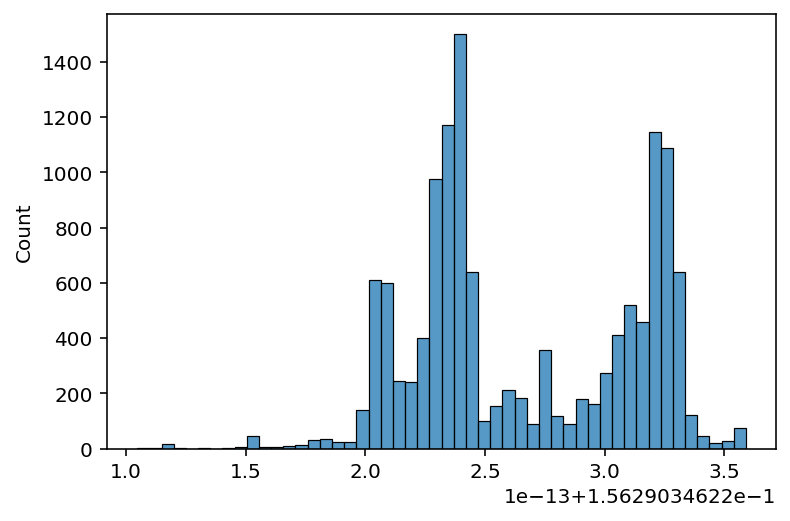

In [ ]:
boxcox_lon, maxlog_lon = stats.boxcox(X_train.longitude.abs() - 50)
sns.histplot(boxcox_lon, bins=50)

* 元のlongitudeを、変換後の値で上書きするには、下のように書けばいいだけ。

In [ ]:
X_train.longitude = boxcox_lon

* 検証データやテストデータにboxcox変換を適用するときは、訓練データでBox-Cox変換したときに得たmaxlogという出力を、必ず利用すること！！！
 * https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

In [ ]:
X_valid.longitude = stats.boxcox(X_valid.longitude.abs() - 50, maxlog_lon) 
X_test.longitude = stats.boxcox(X_test.longitude.abs() - 50, maxlog_lon) 

* 検証データの変換後のlongitudeを確認。

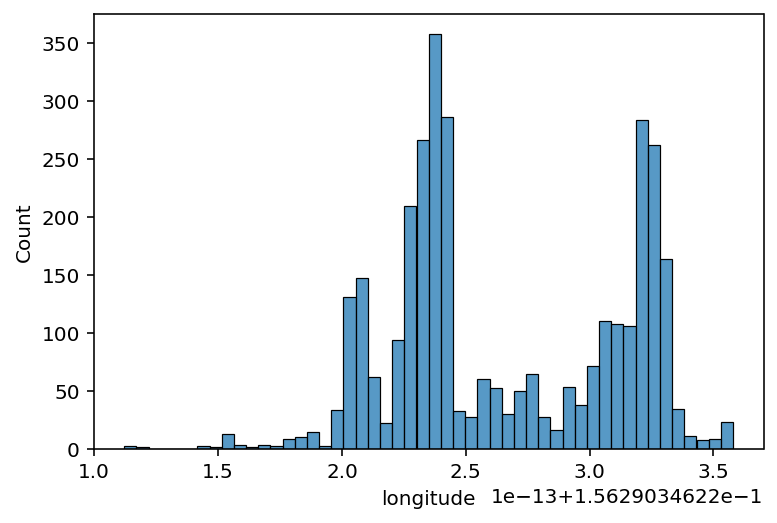

In [ ]:
sns.histplot(X_valid.longitude, bins=50)

## latitudeのBox-Cox変換

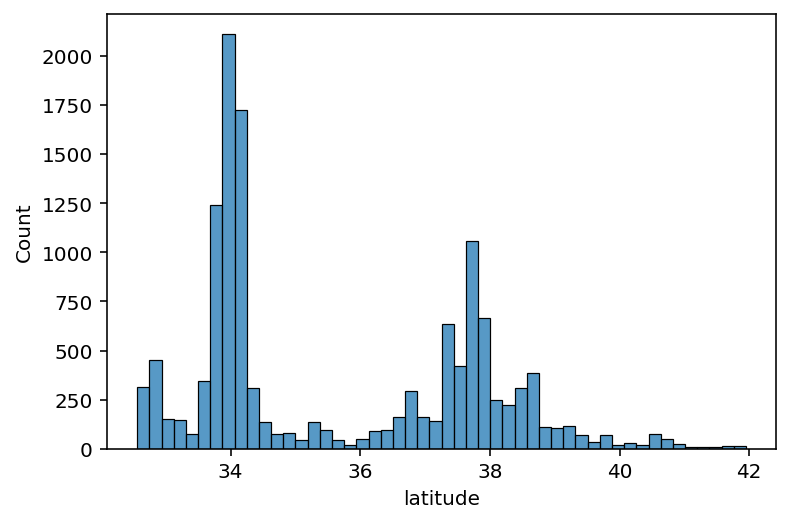

In [ ]:
sns.histplot(X_train.latitude, bins=50)

In [ ]:
boxcox_lat, maxlog_lat = stats.boxcox(X_train.latitude)

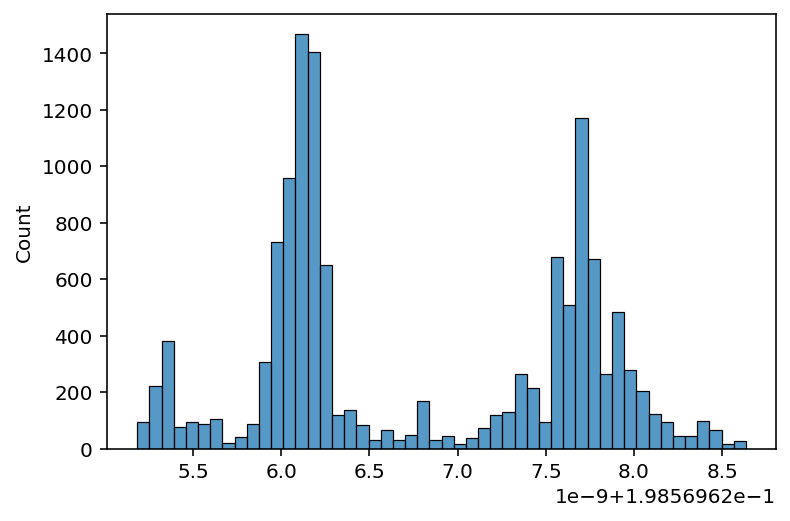

In [ ]:
sns.histplot(boxcox_lat, bins=50)

* これは良さそう。

In [ ]:
X_train.latitude = boxcox_lat
X_valid.latitude = stats.boxcox(X_valid.latitude, maxlog_lat)
X_test.latitude = stats.boxcox(X_test.latitude, maxlog_lat)

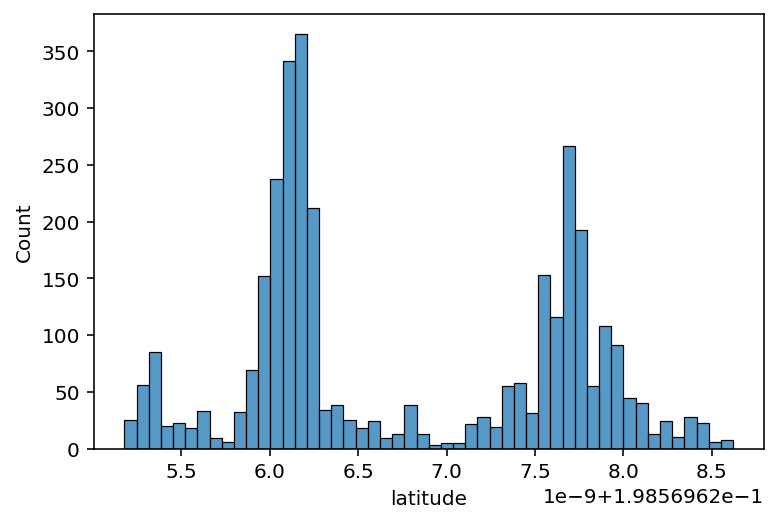

In [ ]:
sns.histplot(X_valid.latitude, bins=50)

## 残りの説明変数もBox-Cox変換してよさそうかをチェック

In [ ]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

* すべてヒストグラムを描いて、そのまま変換して良さそうかどうか、チェックする。

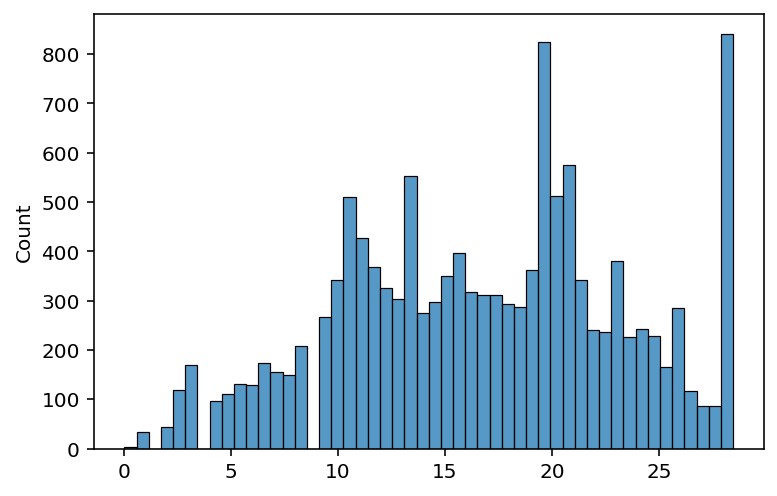

In [ ]:
sns.histplot(stats.boxcox(X_train.housing_median_age)[0], bins=50)

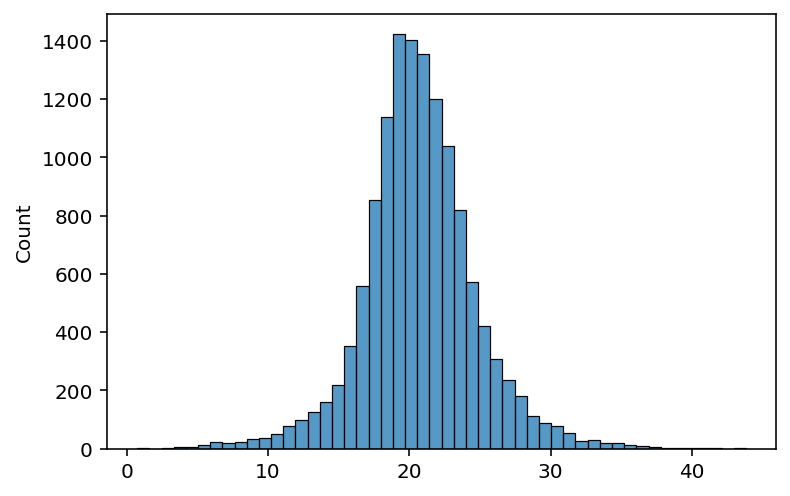

In [ ]:
sns.histplot(stats.boxcox(X_train.total_rooms)[0], bins=50)

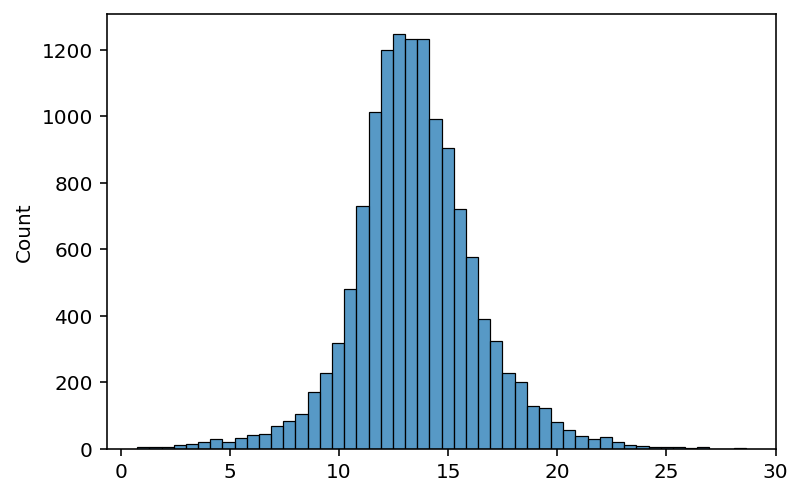

In [ ]:
sns.histplot(stats.boxcox(X_train.total_bedrooms)[0], bins=50)

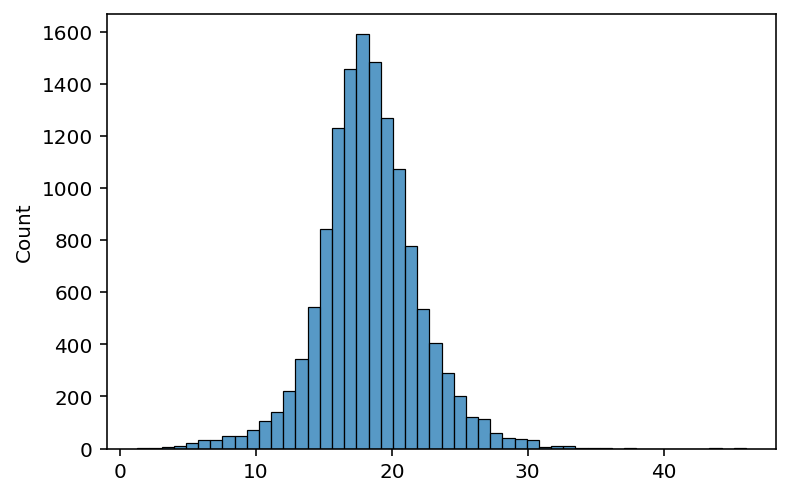

In [ ]:
sns.histplot(stats.boxcox(X_train.population)[0], bins=50)

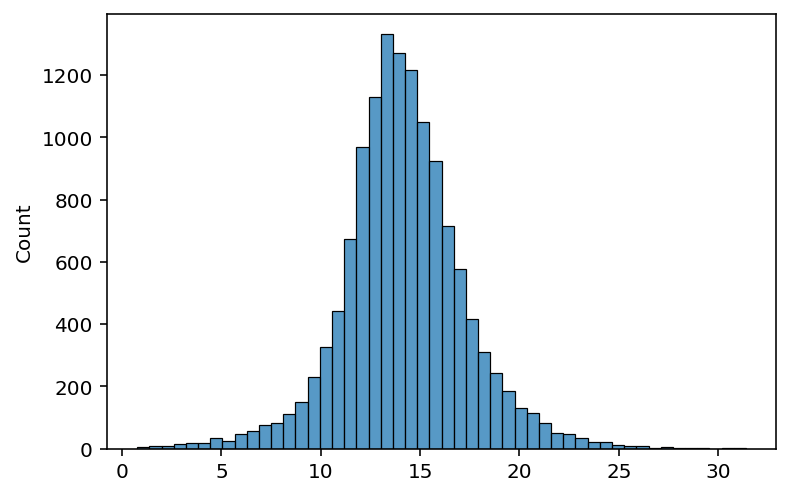

In [ ]:
sns.histplot(stats.boxcox(X_train.households)[0], bins=50)

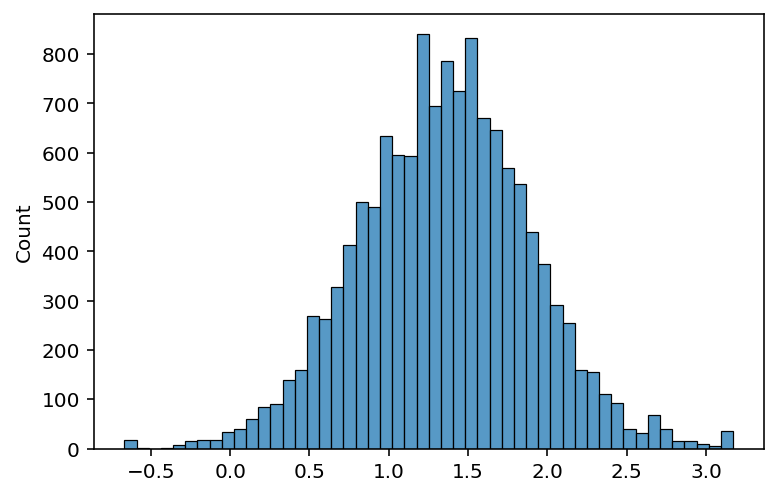

In [ ]:
sns.histplot(stats.boxcox(X_train.median_income)[0], bins=50)

## 残りの説明変数を一括してBox-Cox変換

* 大丈夫そうなので、一括して変換。
 * 検証データとテストデータも変換。

In [ ]:
for column in X_train.columns[2:]:
  boxcox, maxlog = stats.boxcox(X_train[column])
  X_train[column] = boxcox
  X_valid[column] = stats.boxcox(X_valid[column], maxlog)
  X_test[column] = stats.boxcox(X_test[column], maxlog)

In [ ]:
X_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,1.320900e+04,1.320900e+04,13209.000000,13209.000000,13209.000000,13209.000000,13209.000000,13209.000000
mean,1.562903e-01,1.985696e-01,16.813971,20.714739,13.477021,18.334280,14.157065,1.350331
std,4.645449e-14,8.864058e-10,6.630151,4.013673,2.842038,3.699378,3.106065,0.542741
min,1.562903e-01,1.985696e-01,0.000000,0.750319,0.751943,1.254215,0.756942,-0.666788
25%,1.562903e-01,1.985696e-01,11.435677,18.505824,11.845547,16.226870,12.409747,0.992377
50%,1.562903e-01,1.985696e-01,17.351852,20.553380,13.345238,18.205492,14.032378,1.361221
75%,1.562903e-01,1.985696e-01,21.369467,22.872143,15.033911,20.375880,15.873154,1.703367
max,1.562903e-01,1.985696e-01,28.475190,43.829483,28.639777,46.066115,31.401203,3.169969


## 変換後の説明変数の値を使って予測性能を測る

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

reg = make_pipeline(StandardScaler(), SGDRegressor(random_state=123))
reg.fit(X_train, y_train)
y_valid_pred = reg.predict(X_valid)
rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
print(f'RMSE: {rmse:.1f}')

RMSE: 72415.2
